# Range 

La proba pour utombe sur une page est bien réelle avec + de chance 

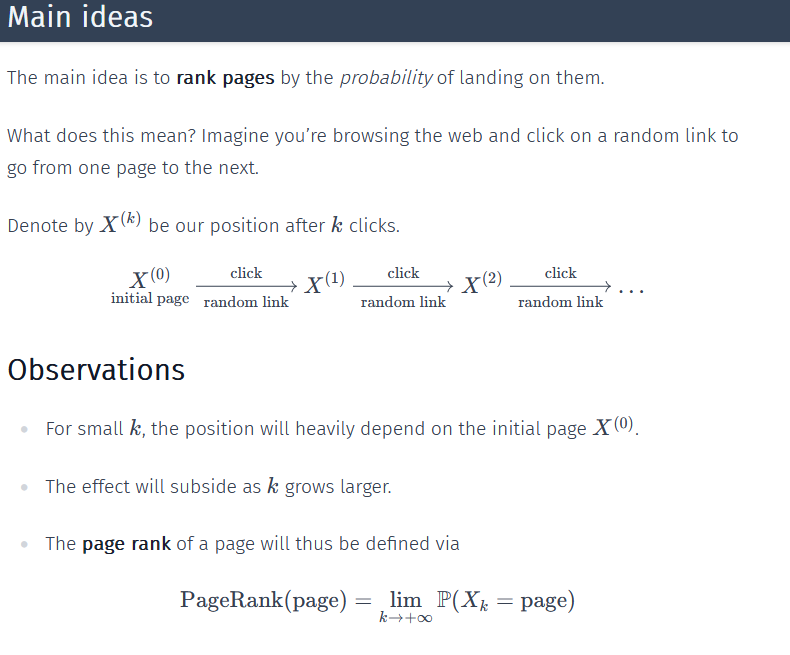

# MAtrice pageRank

- la ligne : les () d'une page 
- la colonne : une page 

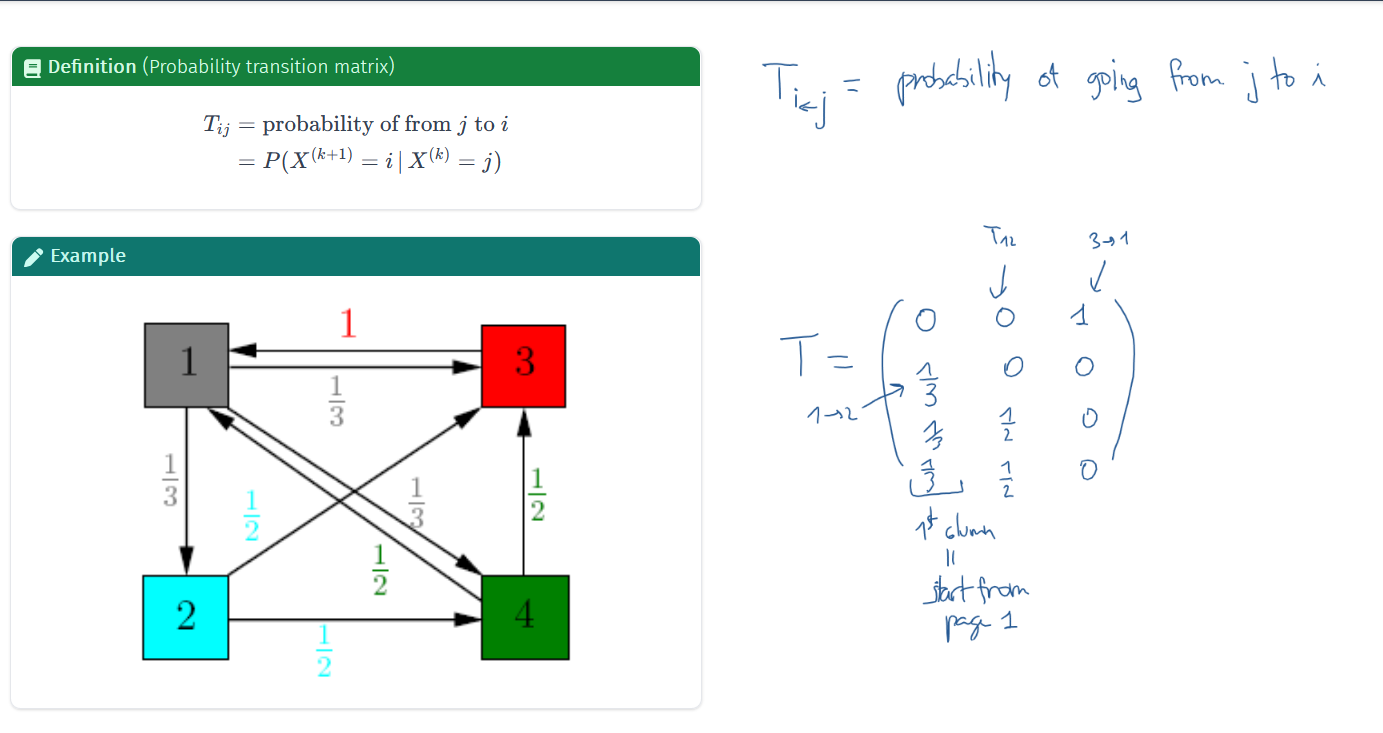

In [6]:
from numpy import matrix, zeros
from numpy.linalg import matrix_power
from pandas import read_csv

edges = read_csv('data/edges.csv')
print(edges)


T = matrix([
    [0, 0, 1, 1/2],
    [1/3, 0, 0, 0],
    [1/3, 1/2, 0, 1/2],
    [1/3, 1/2, 0, 0],   
])
print(T)




p = matrix([[1/4], [1/4], [1/4], [1/4]])

# Sans boucle: puissance de matrice
p = matrix_power(T, 100) @ p
p

          FromNode  ToNode
0           175973       1
1           130880       2
2           145856       2
3           159190       2
4           159200       2
...            ...     ...
10722185    156536  190926
10722186    170697  112376
10722187    177550  108047
10722188    181302   84697
10722189    189293  154081

[10722190 rows x 2 columns]
[[0.         0.         1.         0.5       ]
 [0.33333333 0.         0.         0.        ]
 [0.33333333 0.5        0.         0.5       ]
 [0.33333333 0.5        0.         0.        ]]


matrix([[0.38709677],
        [0.12903226],
        [0.29032258],
        [0.19354839]])

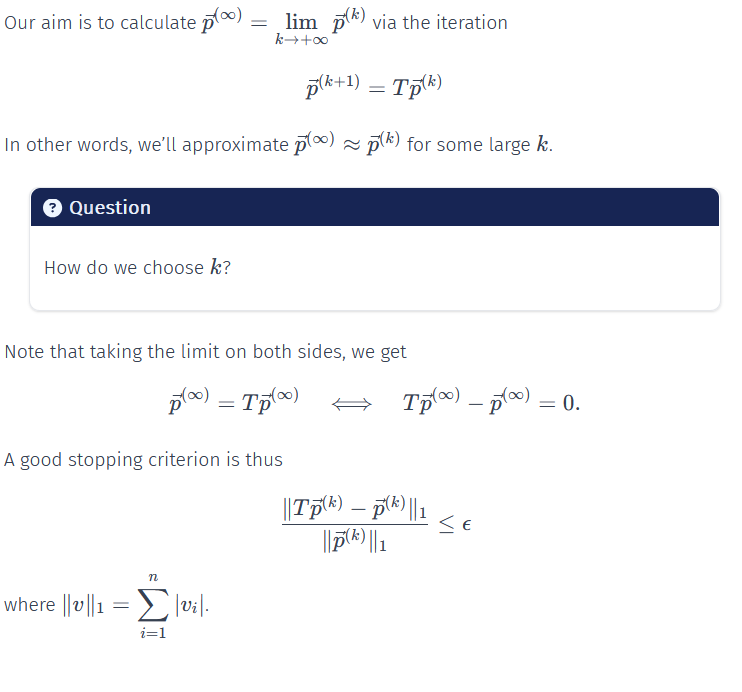

# stockage au memoire

on crée une liste de mat pour pouvoir stk , 

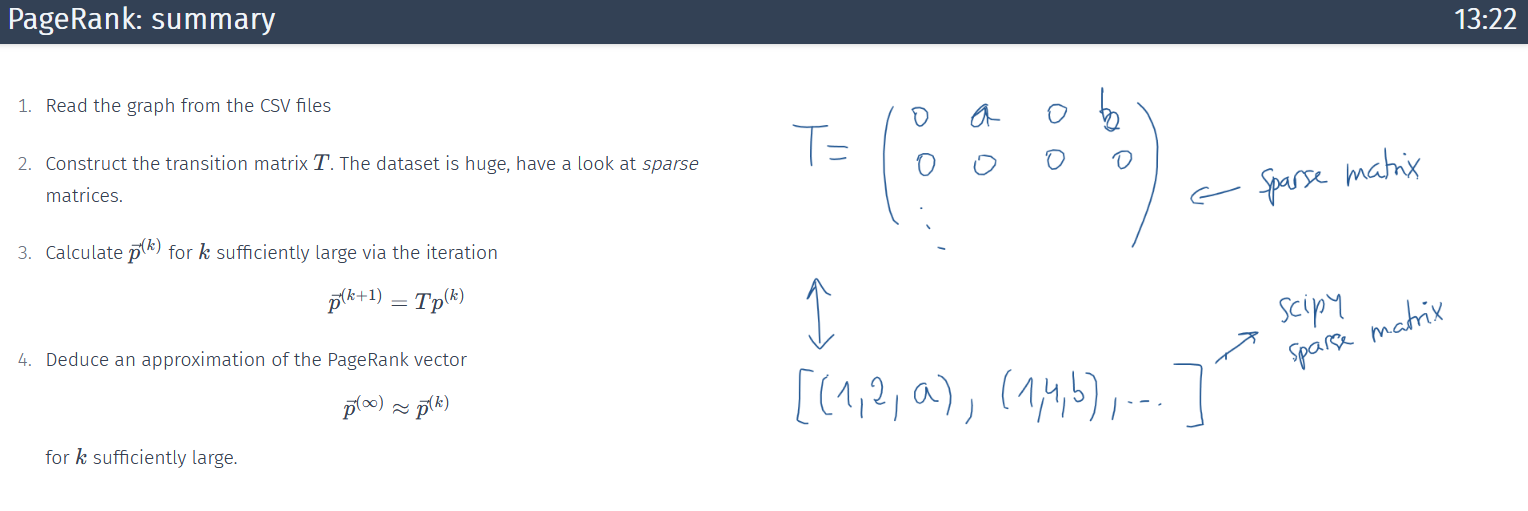

In [34]:
import numpy as np
from math import isclose
import pandas as pd
from scipy.sparse import coo_matrix


edges = pd.read_csv('data/edges.csv')
print(edges)
print(f"Nombre d'arêtes: {len(edges)}")

# Tous les nœuds uniques
nodes = pd.Index(pd.concat([edges['FromNode'], edges['ToNode']]).unique())
print(f"Nombre d'états (nœuds): {len(nodes)}")


node_to_idx = pd.Series(np.arange(len(nodes)), index=nodes)


from_idx = node_to_idx.loc[edges['FromNode']].to_numpy()
to_idx = node_to_idx.loc[edges['ToNode']].to_numpy()


out_degree = np.bincount(from_idx, minlength=len(nodes))
weights = 1.0 / out_degree[from_idx]

# Matrice de transition creuse
T = coo_matrix((weights, (to_idx, from_idx)), shape=(len(nodes), len(nodes))).tocsr()
print('voici ma matrice de transition creuse:', T)

# Vecteur de probabilité initial uniforme
p = np.full(len(nodes), 1 / len(nodes))

# Itérations avec multiplication matricielle 
for _ in range(100):
    p = T @ p



# Résultat : top 10 PageRank
pagerank = pd.DataFrame({
    'node': nodes.to_numpy(),
    'score': p,
    #'max': p.max()
}).sort_values('score', ascending=False)

print("\nTop 100 PageRank:")
print(pagerank.head(100))

          FromNode  ToNode
0           175973       1
1           130880       2
2           145856       2
3           159190       2
4           159200       2
...            ...     ...
10722185    156536  190926
10722186    170697  112376
10722187    177550  108047
10722188    181302   84697
10722189    189293  154081

[10722190 rows x 2 columns]
Nombre d'arêtes: 10722190
Nombre d'états (nœuds): 199903
Nombre d'états (nœuds): 199903
voici ma matrice de transition creuse: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 10722190 stored elements and shape (199903, 199903)>
  Coords	Values
  (0, 55)	0.003861003861003861
  (0, 56)	0.0049261083743842365
  (0, 113)	0.015384615384615385
  (0, 848)	0.006993006993006993
  (0, 1153)	0.009900990099009901
  (0, 3641)	0.0010570824524312897
  (0, 9494)	0.0125
  (0, 10467)	0.022727272727272728
  (0, 10937)	0.0033783783783783786
  (0, 11269)	0.0036900369003690036
  (0, 11467)	0.024390243902439025
  (0, 12408)	0.019230769230769232
  (0

In [61]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.sparse import coo_matrix

edges = pd.read_csv('data/edges.csv')
print(f"Nombre d'arêtes: {len(edges)}")

# Charger le fichier de noms
names_path = Path('data/names.csv')
print(f'names.csv existe: {names_path.exists()}')

if names_path.exists():
    names_df = pd.read_csv(names_path, header=None, names=['Name'])
    print(f"Nombre de noms chargés: {len(names_df)}")
else:
    names_df = None

# Tous les nœuds uniques
nodes = pd.Index(pd.concat([edges['FromNode'], edges['ToNode']]).unique())
print(f"Nombre d'états (nœuds): {len(nodes)}")

node_to_idx = pd.Series(np.arange(len(nodes)), index=nodes)

# Convertir en indices numériques
from_idx = node_to_idx.loc[edges['FromNode']].to_numpy()
to_idx = node_to_idx.loc[edges['ToNode']].to_numpy()

# Calcul des poids (1 / out_degree)
out_degree = np.bincount(from_idx, minlength=len(nodes))
weights = 1.0 / out_degree[from_idx]

# Matrice de transition creuse
T = coo_matrix((weights, (to_idx, from_idx)), shape=(len(nodes), len(nodes))).tocsr()

# Vecteur de probabilité initial uniforme
p = np.full(len(nodes), 1 / len(nodes))

# Critère d'arrêt sur l'erreur relative
max_iter = 500
eps = 1e-12
for k in range(max_iter):
    p_new = T @ p
    denom = np.abs(p_new).sum()
    rel_err = np.abs(p_new - p).sum() / denom if denom > 0 else np.inf
    p = p_new
    if rel_err < eps:
        break

pagerank = pd.DataFrame({
    'node': nodes.to_numpy(),
    'score': p
}).sort_values('score', ascending=False).reset_index(drop=True)

# Ajouter les noms si disponibles
if names_df is not None:
    pagerank['name'] = pagerank['node'].apply(lambda x: names_df.iloc[x, 0] if x < len(names_df) else 'Unknown')

# Index et valeur du score maximal
idx_max = int(np.argmax(p))
node_max = nodes[idx_max]
score_max = float(p[idx_max])
name_max = names_df.iloc[idx_max, 0] if names_df is not None and idx_max < len(names_df) else 'Unknown'

print(f"\nConvergence en {k+1} itérations, erreur relative = {rel_err:.2e}")
print(f"\nIndex max = {idx_max}, node = {node_max}, score = {score_max:.6e}")
print(f"Nom du nœud maximal: {name_max}")

print("\nTop 1000 PageRank")
if names_df is not None:
    print(pagerank[['node', 'name', 'score']].head(1000))
else:
    print(pagerank[['node', 'score']].head(1000))

Nombre d'arêtes: 10722190
names.csv existe: True
Nombre de noms chargés: 199904
Nombre d'états (nœuds): 199903
Nombre d'états (nœuds): 199903

Convergence en 186 itérations, erreur relative = 9.28e-13

Index max = 2768, node = 112356, score = 2.490766e-03
Nom du nœud maximal: ChristianUnion

Top 1000 PageRank
       node                                 name     score
0    112356                        United States  0.002491
1    168241                       United Kingdom  0.001390
2    138128                         World War II  0.001131
3    184958                                Latin  0.001084
4     60041                               France  0.001077
..      ...                                  ...       ...
995  177853                       Czech language  0.000080
996   83011                             Rhetoric  0.000079
997   51888  Dimension (mathematics and physics)  0.000079
998   16295                       South Carolina  0.000079
999   46331                      Silicon